# What Happened to Crime Activity in Seattle?

This is part 2 of a project I initially started as a means of finding a place to live. I ended up moving before finishing the project, but the data was interesting enough to motivate me to finish it. While the primary overall goal of this project is to determine the quality of life throughout Seattle, I have a few secondary goals for this part of the project:
<ol>
    <li>Find out how criminal activity has changed with time in Seattle
    <li>Find out how much each Seattle neighborhood has experienced criminal activity
    <li>Consolidate this new information with past information on code violations to figure out the best neighborhoods
</ol>

In this part, I use data from my previous look at code violations in Seattle (in the time domain) as well as criminal activity data provided by [data.seattle.gov](data.seattle.gov). I will also use time series analysis methods I first encountered in [JTEST](TEst), and chloropleth creation code I encountered in [TEST](www.TEST.com)

## The Data

I use two data sets in part 2. The first contains 608291 logged [criminal cases](https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Police-Report-Incident/i6vm-ucwh) around Seattle 2006-2016 (there are a bunch of outlying points that I will get to). This data was accessed 04/04/2016 but only goes up to 02/27/2016. The cases range from petty theft to homicide and, if a case has more than one offense, it is logged multiple times. These are offenses that were called in by someone, responded to, and officially entered into the police records. Among other information, this set lists offense type, date, and location.
The second data set is the code violation data from part 1 to figure out locational information for all the data sets.

## The Analysis

Using the same methods as in the previous part, I will use Pandas, Matplotlib, and Numpy for most all of the analysis. Using timestamps from the crime data, I can make timeseries' that make certain types of analysis easier.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

crimes = pd.read_csv('crimes.csv', index_col='Date Reported', parse_dates=True)

Here are the headers for the 'crimes' dataset, and an example of what it looks like.

In [2]:
crimes.head(1)

,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year
Date Reported,,,,,,,,,,,,,,,,,,
2016-02-27 22:26:00,648460,201670728,3542,1,NARC-POSSESS-METH,3500,NARCOTICS,02/27/2016 10:26:00 PM,NaN,5 AV S / S MAIN ST,K,K3,9200.1012,-122.327667,47.600033,"(47.600032806, -122.327667236)",2,2016


Here is a look at amounts of the different types of offenses listed in this dataset. The offense descriptions are sometimes in all caps or with the beginning letters capitalized, so I can combine these with Pandas to avoid having separate listings.

In [3]:
crimes['Summarized Offense Description'].str.capitalize().value_counts()

Vehicle theft               22
Other property              12
Burglary                     8
Threats                      8
Assault                      8
Warrant arrest               7
Narcotics                    6
Trespass                     4
Robbery                      4
Shoplifting                  3
Dui                          2
Weapon                       2
Property damage              2
Disturbance                  2
Stolen property              1
Violation of court order     1
Fraud                        1
Theft of services            1
[inc - case dc use only]     1
Mail theft                   1
Car prowl                    1
Lost property                1
Counterfeit                  1
Name: Summarized Offense Description, dtype: int64

Now for some cleaning up. Turns out that there are a lot of entries that have only part of the information filled in, having either missing entries or have filler entries such as lat/longitude being set to zero. There is scarce, incomplete data stretching back to 1989, but 2008 is where the entries become much more regular. There are also offenses listed as '[inc - case dc use only]', which I can only assume are redacted reports that I cannot use.

Last, I strip away headers that I don't think are useful, e.g. we don't need 'location' if we have 'latitude' and 'longitude'. Really, the things I care about are the types of offenses and also where and when they happened.

In [4]:
crimes = crimes[['Summarized Offense Description','District/Sector', 'Zone/Beat', 'Latitude', 'Longitude']].dropna()
crimes = crimes[(crimes['Latitude'] != 0.0) & (crimes['Longitude'] != 0.0)]
crimes = crimes[:'2008-01-01']
crimes = crimes[crimes['Summarized Offense Description'].str.capitalize() != '[inc - case dc use only]']
len(crimes)

98

So after some cleaning up, there are now 602893 fine points of data.

Now, the two main things I want to do with this data are: 1) Figure out how crime has changed with time and 2) Figure out how crime counts are distributed throughout the city. However, there is a big spread in the kinds of offenses that are considered criminal activity. Something like fireworks does not bother me as much as homicide being nearby. 
My solution to this is to split up the criminal cases into "very bad to have nearby" and "not quite as bad to have nearby", which I call severe and mild. That is not to say I would want to live around the mild offenses, just that these severe offenses are very easy to point at and say "this makes a neighborhood unsafe."

In [5]:
severeoffense = np.array(['Assault', 'Threats', 'Narcotics', 'Weapon', 'Burglary', 'Homicide', 'Robbery', 'Car prowl', 'Pornography`'])
crimes['Severe'] = np.in1d(crimes['Summarized Offense Description'].str.capitalize(), severeoffense)

So here is a first look at how crime counts have changed in time since 2008 for both kinds of crimes

/home/ray/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=553.0, right=553.0
  'left=%s, right=%s') % (left, right))


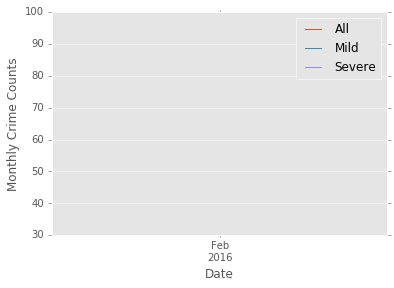

In [6]:
crime_counts = pd.DataFrame({'Severe': pd.Series(crimes[crimes['Severe'] == True].index.value_counts().resample('M', how='sum')),
                                    'Mild': pd.Series(crimes[crimes['Severe'] == False].index.value_counts().resample('M', how='sum')),
                                    'All': pd.Series(crimes.index.value_counts().resample('M', how='sum'))})
crime_counts = crime_counts.fillna(0)
crime_counts.plot()
plt.xlabel('Date')
plt.ylabel('Monthly Crime Counts')

There are blocks of time within 2011 and 2013-2015 where the number of all reported crimes, mild and severe, increases by something like a factor of 2. This drops off before 2012 and once more before 2015, after which it returns to numbers slightly higher than pre-2011.

In [7]:
crime_counts[:'2011-01-01'].describe()

,All,Mild,Severe
count,0,0,0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In [8]:
crime_counts['2013-01-01':'2015-01-01'].describe()

,All,Mild,Severe
count,0,0,0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In fact, the mean number of reported crimes between 2013-2015 is very close to 2x higher than between pre-2011. The minimum reported each month is much higher and the spread is 2x larger between 2011-2015. What is this heightening of reported criminal activity?

Using methods from part 1, I can isolate contributions from seasonal variations:

In [9]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

In [10]:
crime_counts['Daylight Hours'] = pd.Series(crime_counts.index.map(hours_of_daylight), index=crime_counts.index)

In [11]:
from sklearn.linear_model import LinearRegression

X = crime_counts['Daylight Hours'][:,np.newaxis]
y1 = crime_counts['Severe'][:,np.newaxis]
y2 = crime_counts['Mild'][:,np.newaxis]
fit1 = LinearRegression().fit(X,y1)
fit2 = LinearRegression().fit(X,y2)

crime_counts['Trend1S'] = fit1.predict(X)
crime_counts['Trend1M'] = fit2.predict(X)
crime_counts['Detrended1S'] = crime_counts['Severe'] - crime_counts['Trend1S'] + crime_counts['Trend1S'].mean()
crime_counts['Detrended1M'] = crime_counts['Mild'] - crime_counts['Trend1M'] + crime_counts['Trend1M'].mean()

So here is what it looks like without seasonal variations. It does not really make much difference.

/home/ray/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=553.0, right=553.0
  'left=%s, right=%s') % (left, right))


Detrended1S   NaN
Severe        NaN
Detrended1M   NaN
Mild          NaN
dtype: float64

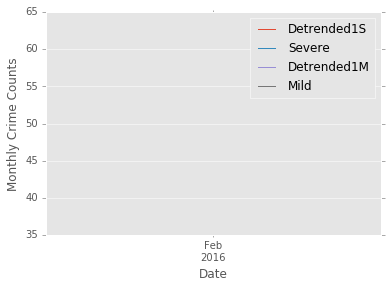

In [12]:
crime_counts[['Detrended1S','Severe','Detrended1M','Mild']].plot()
plt.xlabel('Date')
plt.ylabel('Monthly Crime Counts')
crime_counts[['Detrended1S','Severe','Detrended1M','Mild']].std()

The truth is that, even after a lot of searching, I cannot actually find anything that properly explains why this big jump in reported cases happens. I can take a look at the top 5 kinds of offenses to see if something is skewing the results...

/home/ray/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=553.0, right=553.0
  'left=%s, right=%s') % (left, right))


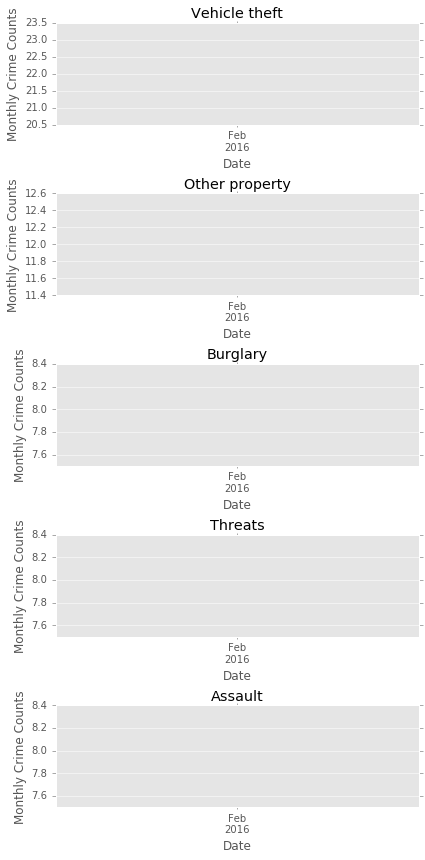

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6,12))

descriptions = crimes['Summarized Offense Description'].str.capitalize()
offenses = [descriptions.value_counts().index[i] for i in range(5)]

for i in range(5):
    descriptions[descriptions == offenses[i]].index.value_counts().resample('M', how='sum').plot(ax=axes[i])
    axes[i].set_title(str(offenses[i]))
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Monthly Crime Counts')
fig.tight_layout()

But they all have roughly the same anomaly! I can split it up by district (which was a pain to figure out each sector's designation):

In [14]:
dist = crimes['District/Sector']
distN = crimes[(dist == 'B') | (dist == 'N') | (dist == 'L') | (dist == 'J') | (dist == 'U')]
distS = crimes[(dist == 'O') | (dist == 'R') | (dist == 'S')]
distE = crimes[(dist == 'E') | (dist == 'C') | (dist == 'G')]
distW = crimes[(dist == 'Q') | (dist == 'D') | (dist == 'M') | (dist == 'K')]
distSW = crimes[(dist == 'W') | (dist == 'F')]

/home/ray/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=553.0, right=553.0
  'left=%s, right=%s') % (left, right))


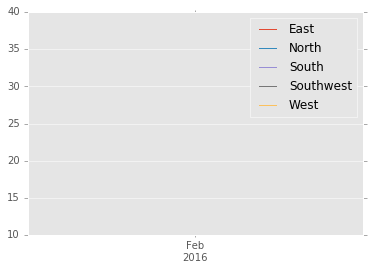

In [15]:
dist_tot = pd.DataFrame({'North': distN.index.value_counts(), 'South': distS.index.value_counts(),
                         'East': distE.index.value_counts(), 'West': distW.index.value_counts(),
                         'Southwest': distSW.index.value_counts()})

dist_tot.resample('M', how='sum').plot()

And again, this does not really show anything past this being a city-wide jump in reporting of all kinds of crimes. This could be some kind of internal policy change on general policing and reporting, or it could be a change in how much data was actually put online. Frankly, I have no idea!

Next, I look at the locational information contained in both the crime and code violation data sets through the use of neat maps called choropleths. They give a visual representation of how the counts are distributed throughout each neighborhood of Seattle. Big thanks to Tyler Hartley for coding exactly what I was looking for (http://beneathdata.com/how-to/visualizing-my-location-history/). His writeups are great, I highly recommend checking his stuff out. Most of the code from here on out is taken and modified from the above link.

First I read in the old code violations data and use only data from 2008-present to match the crime data.

In [16]:
violations = pd.read_csv('violations.csv', header=0, index_col='Date Case Created', parse_dates=True)
violations = violations[:'2008-01-01']

The code for creating the choropleth map is too long to have here, but it can be found in its original form on [Tyler Hartey's website](http://beneathdata.com/how-to/visualizing-my-location-history/), or in its module form on my [Github](https://gist.github.com/RaySSharma/5077ad8e2d8ea442b085923d5b2133d4).

In [17]:
import choropleth as ch
severe = crimes['Severe'] == True
mild = crimes['Severe'] == False

I want 4 choropleth maps: one for all code violations, one for all crime reports, then two for mild&severe crimes only. All the module needs is the shapefile, input data, desired figure size, and labels for titles and output image!

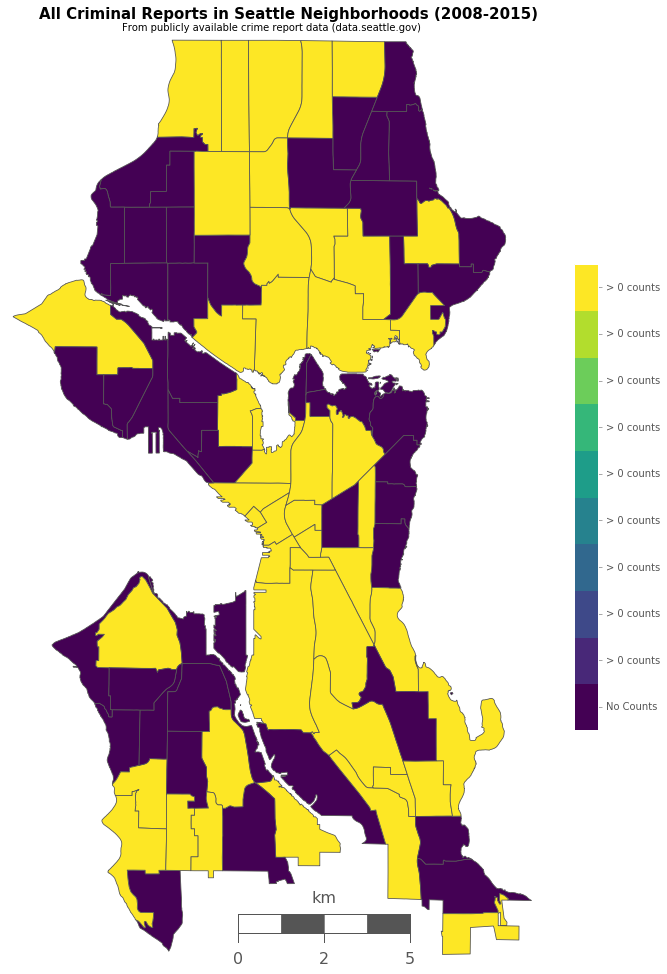

In [18]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available crime report data (data.seattle.gov)'
suptitle = 'All Criminal Reports in Seattle Neighborhoods (2008-2015)'
savename = 'allcrime.png'
cmap = plt.get_cmap('viridis')
count1, name1, point_name1 = ch.choropleth(shapefilename, cmap, crimes['Latitude'], crimes['Longitude'], title, suptitle, savename, figwidth)

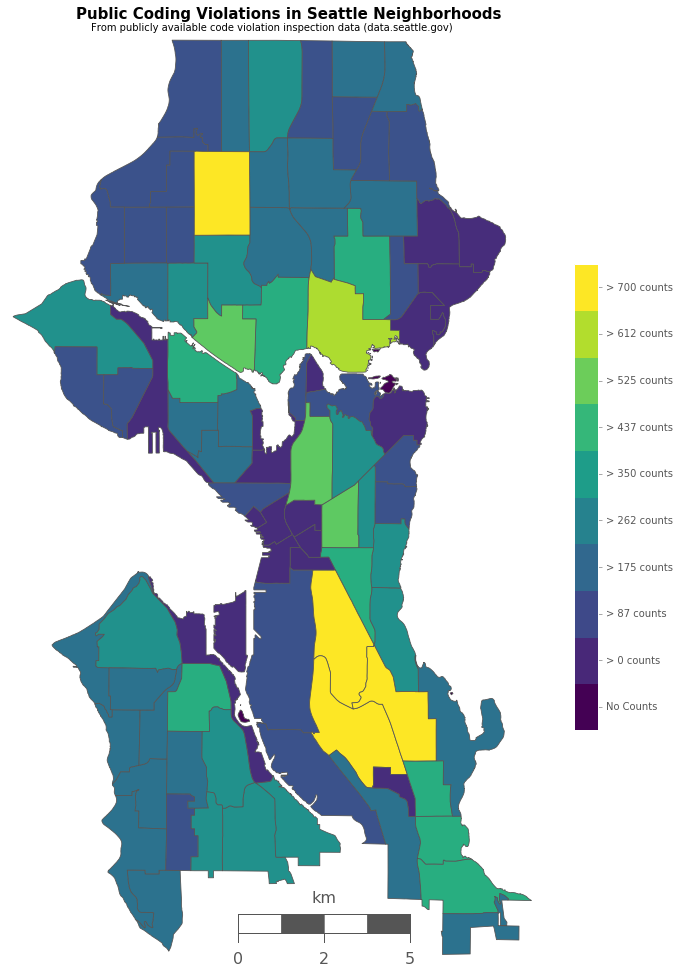

In [19]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available code violation inspection data (data.seattle.gov)'
suptitle = 'Public Coding Violations in Seattle Neighborhoods'
savename = 'allviolations.png'
cmap = plt.get_cmap('viridis')
count2, name2, point_name2 = ch.choropleth(shapefilename, cmap, violations['Latitude'], violations['Longitude'], title, suptitle, savename, figwidth)

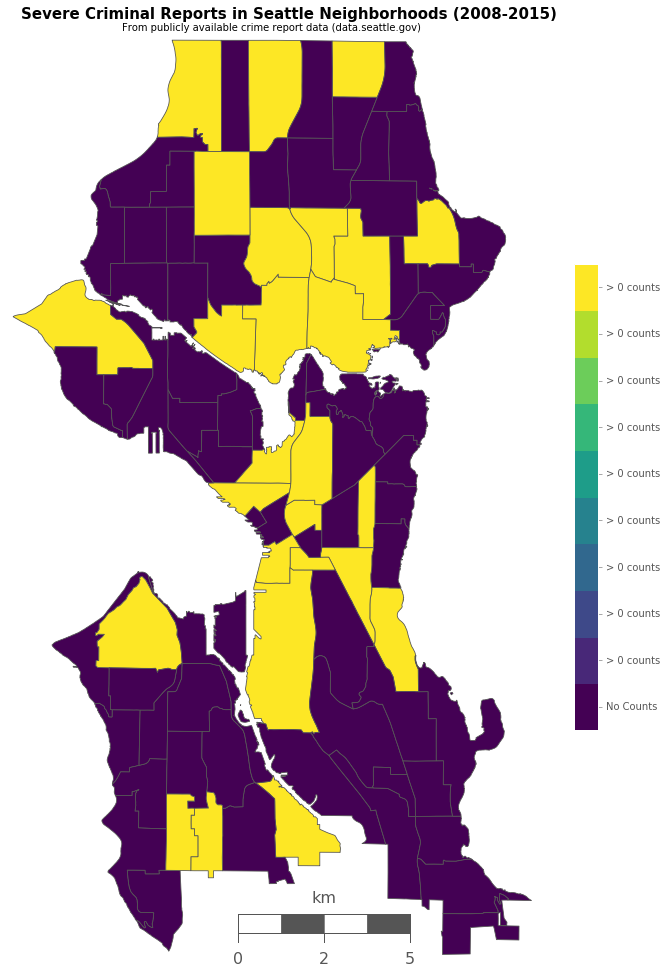

In [20]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available crime report data (data.seattle.gov)'
suptitle = 'Severe Criminal Reports in Seattle Neighborhoods (2008-2015)'
savename = 'severecrime.png'
cmap = plt.get_cmap('viridis')
count3, name3, point_name3 = ch.choropleth(shapefilename, cmap, crimes[severe]['Latitude'], crimes[severe]['Longitude'], title, suptitle, savename, figwidth)

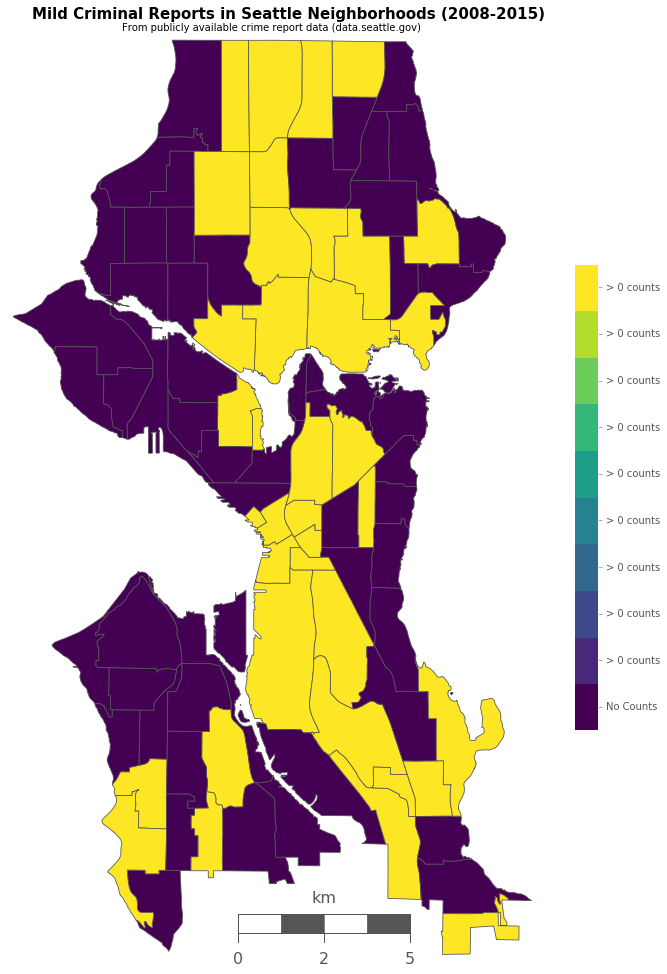

In [21]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available crime report data (data.seattle.gov)'
suptitle = 'Mild Criminal Reports in Seattle Neighborhoods (2008-2015)'
savename = 'mildcrime.png'
cmap = plt.get_cmap('viridis')
count4, name4, point_name4 = ch.choropleth(shapefilename, cmap, crimes[mild]['Latitude'], crimes[mild]['Longitude'], title, suptitle, savename, figwidth)

From the looks of it, southwest, northeast, and northwest Seattle do not see too much criminal activity. Northeast and Downtown Seattle do not see too many coding violations. Severe and mild crimes tend to happen in roughly the same areas and so the maps look very similar.

There are a few ways to decide which neighborhoods are the best/worst. I can look at which neighborhoods have the highest relative numbers of both code violations and crime activity (severe and/or mild). I can also look at which neighborhoods are on the rise for code violations and crime activity.

First I clean the patches up since some neighborhoods are not given an official name so I can't say which is which. Additionally, some districts have 0 counts of anything, and so these do not matter anyway. 

In [22]:
def norm(X):
    return (X-X.min()) / (X.max() - X.min())

df = pd.DataFrame({'Names': name1,
                  'AllCrimes': count1,
                  'Violations': count2,
                  'SevereCrimes': count3,
                  'MildCrimes': count4})
df = df[df['AllCrimes'] > 0.]
df = df[df['Names'] != 'OOO']

I can normalize crimes and codes separately then add together to find the most/least influenced neighborhoods.

In [23]:
df['NormalAll'] = norm(df['AllCrimes']) + norm(df['Violations'])
df = df.sort_values('NormalAll', ascending=False)
df.index = range(1, len(df)+1)
df

,AllCrimes,MildCrimes,Names,SevereCrimes,Violations,NormalAll
1,10,6,Broadway,4,506,1.725076
2,6,3,Greenwood,3,688,1.555556
3,3,1,University District,2,594,1.080228
4,2,2,North Beacon Hill,0,665,1.076368
5,4,3,Fremont,1,452,0.976838
6,1,1,Mid-Beacon Hill,0,639,0.925982
7,2,1,Wallingford,1,401,0.677576
8,4,2,Roosevelt,2,228,0.638469
9,2,1,Ravenna,1,365,0.623196
10,6,6,Central Business District,0,59,0.605404


Broadway is the worst neighborhood according to this method, followed by University District, Greenwood, and Columbia City in south Seattle. At a first glance it is a surprise the Central Business District isn't higher up, but it has low numbers of code violations probably due to its small size and lack of residential zoning. The Central Business District does have the highest amount of crime activity for such a tiny neighborhood.

I am glad to see that my current neighborhood, Cedar Park, is 36th place -- much better than my previous neighborhood of University District!